In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("derrom/")
sys.path.append("ELPH/")
sys.path.append("utils/")

import derrom
import ivp_integrator
import PHELPH


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.02
system.tau_photon = 200
system.E_photon = 0.0175
system.linewidth = 0.005

# v = 'v3'
# system.g_photon = 0.01
# system.tau_photon = 500
# system.E_photon = 0.0175
# system.linewidth = 0.005

system.setup_laser()

In [3]:
I_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_I_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_trajectories = derrom.utils.load_trajectories(filename='../PHELPH_el_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_scattering = derrom.utils.load_trajectories(filename='../PHELPH_el_scat_kmax2.5_nkmax_100_n1000_'+v+'.npz')

n_sample = 1

I_trajectories = I_trajectories[::n_sample]
el_trajectories = el_trajectories[::n_sample]
el_scattering = el_scattering[::n_sample]

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


cutoff = int(n_trajectories*0.9)

train_I_trajectories = I_trajectories[:cutoff]
train_el_trajectories = el_trajectories[:cutoff]
train_el_scattering = el_scattering[:cutoff]

test_I_trajectories = I_trajectories[cutoff:]
test_el_trajectories = el_trajectories[cutoff:]
test_el_scattering = el_scattering[cutoff:]

test_trajectories = trajectories[cutoff:]


1000 loaded with n_kmax = 100


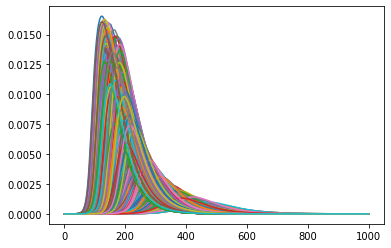

In [4]:
for I in I_trajectories:
    plt.plot(I)
    
plt.show()

In [5]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(train_el_trajectories, train_el_scattering, rdim=10, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

el_scat_model.train()

el_scat_model.print_status()

full_hist:  False
intercept:  True
standardize:  True
rdim:  10
DE_l:  2
weights shape:  (1021, 100)


In [6]:
def derivs(y):
    
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]
    
    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)
    
    
    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9
    
    return np.concatenate((df[0],[dI]))

In [7]:
integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: mu_start= 0.1 ,T_start= 300
calc_fermi_CC_eh: dens= -0.12962215427169696 , en= 0.005275957815214317
calc_fermi_CC_eh: d= 5.565278136899877e-06 , E= 1.2170188728858927e-06
calc_fermi_CC_eh: mu= -9.89999999999998 , T= 10300.0
calc_fermi_CC_eh: error= 1.0000429346215403  nach  99  Schritten
fit_mu braucht mehr als STEP_LIMIT Schritte!
calc_fermi_CC_eh: Jacobi_Det wird null!!!
     d= 0.41638911986417115   mu= 0.4   E= 0.08300954842280328   T= 0.0
rms error: 0.00720142990231784
max error: 0.03857445850251662
I_max error: 0.00011042685183861208
I_max_pos error: -1
I_area error: 0.03093222950185992


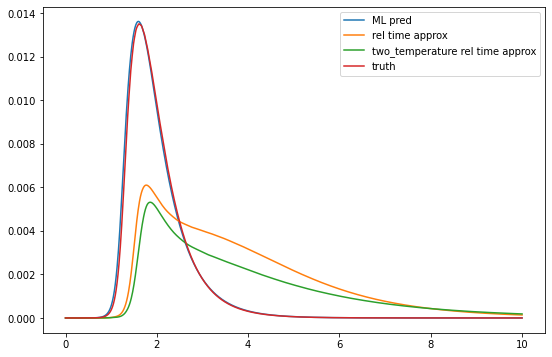

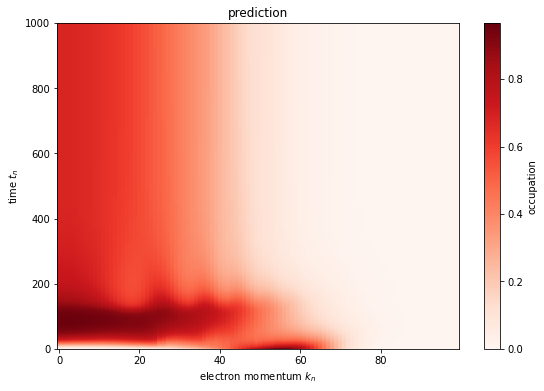

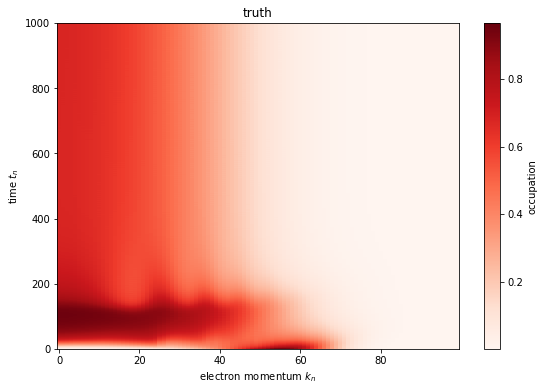

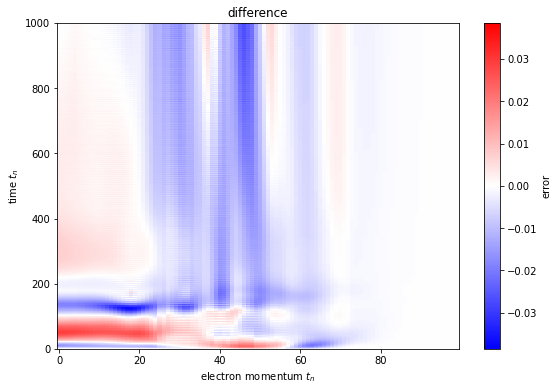

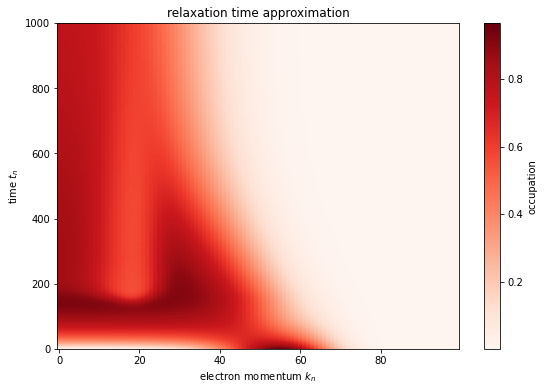

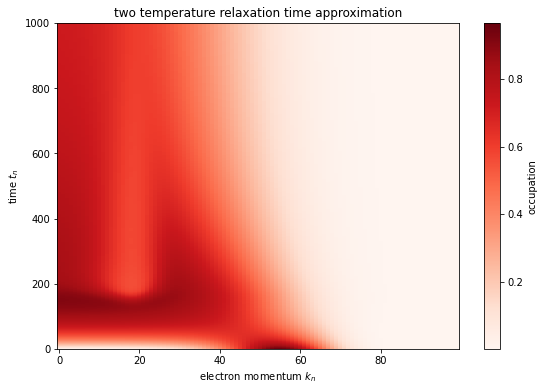

In [40]:
ind = 3

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]

inits = test_trajectory[:1]

pred = integrator.integrate(test_trajectory,test_el_trajectory.shape[0])


rel_time_approx = system.rel_time_approx(inits.flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=500)


ttrt_inits = np.concatenate([test_trajectory[0,:system.n_kmax],[system.T_cryo],[test_trajectory[0,-1]]])
ttrt_approx = system.two_temperature_rel_time_approx(ttrt_inits,tmax=tmax, n_tmax=n_tmax,tau_rel=500,tau_Tp=4000)


print('rms error:', integrator.get_error(test_trajectory,pred, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,pred, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,pred, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,pred, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,pred, norm='I_area'))


plt.plot(t_vec/1000,pred[:,-1],label='ML pred')
plt.plot(t_vec/1000,rel_time_approx[:,-1],label='rel time approx')
plt.plot(t_vec/1000,ttrt_approx[:,-1],label='two_temperature rel time approx')
plt.plot(t_vec/1000,test_I_trajectory,label='truth')
plt.legend()
plt.show()


derrom.utils.plot_trajectory(pred[:,:-1],title='prediction')

derrom.utils.plot_trajectory(test_el_trajectory,title='truth')

derrom.utils.plot_difference(truth=test_el_trajectory,test=pred[:,:-1])

derrom.utils.plot_trajectory(rel_time_approx[:,:-1],title='relaxation time approximation')

derrom.utils.plot_trajectory(ttrt_approx[:,:-2],title='two temperature relaxation time approximation')


# plt.plot(system.E_el_vec,test_el_trajectory[-1],label='truth')
# plt.plot(system.E_el_vec,pred[-1,:-1],label='ML')
# plt.plot(system.E_el_vec,rel_time_approx[-1,:-1],label='rta')
# plt.plot(system.E_el_vec,ttrt_approx[-1,:-2],label='ttrta')
# plt.legend()
# plt.show()


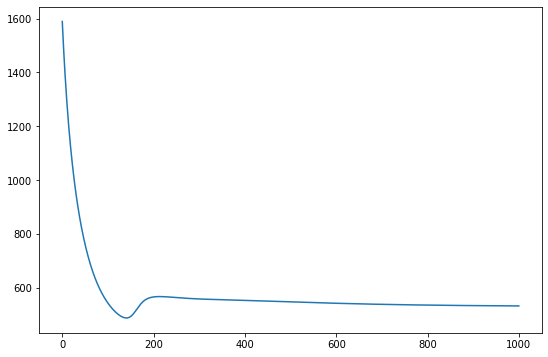

In [39]:
sys.path.append("../utils/")
import fermi_fit
fermi_fitter = fermi_fit.fermi_fit(system.DOS_vec, system.E_el_vec, system.kB)

Te_vec = []
mus = []
Steps = []

ind_start = 0

for k in range(ttrt_approx[ind_start:,:-2].shape[0]):
    mu,Temp,steps = fermi_fitter.fit_mu_T(ttrt_approx[ind_start:,:-2][k], 0.1, 300, False)
    mus.append(mu)
    Te_vec.append(Temp)
    Steps.append(steps)

Te_vec = np.asarray(Te_vec)
    
plt.plot(Te_vec)
plt.show()

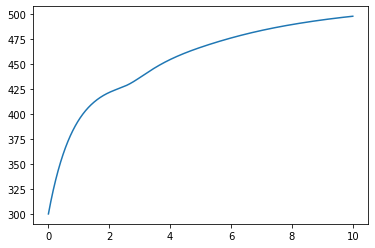

In [17]:
plt.plot(t_vec/1000,ttrt_approx[:,-2],label='two_temperature rel time approx')
plt.show()

In [ ]:
mean, mscores = integrator.score_multiple_trajectories(test_trajectories, norm='I_max')

print(mean)

plt.hist(mscores,bins=10)
plt.show()

In [ ]:
dim_reducer = derrom.dim_reducers.SVD()

scaler = derrom.scalers.standardize_scaler(1.0)
transformer = derrom.transformers.ELM_features(ELM_nodes=1000)
optimizer = derrom.optimizers.ridge(alpha=10.**4)

# scaler = derrom.scalers.normalize_scaler(0.1)
# transformer = derrom.transformers.polynomial_features(order=2)
# optimizer = derrom.optimizers.ridge(alpha=10.**-2.)

el_scat_model = derrom.derrom(rdim=10, DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

integrator = ivp_integrator.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

scores = derrom.utils.get_KFold_CV_scores(integrator, trajectories, el_scattering, folds=10, seed=817,
                                          norms=['rms','max','I_max','I_max_pos','I_area'],
                                          train_kwargs={})

print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(scores[2])) + ' +- ' + str(np.std(scores[2])) )
print('I_max_pos error: ', str(np.mean(scores[3])) + ' +- ' + str(np.std(scores[3])) )
print('I_area error: ', str(np.mean(scores[4])) + ' +- ' + str(np.std(scores[4])) )

In [ ]:
mean_I_max = np.mean([I.max() for I in I_trajectories])
print(mean_I_max)
mean_I_area = np.mean([np.sum(I) for I in I_trajectories])
print(mean_I_area)


print('rms error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )
print('I_max error: ', str(np.mean(np.abs(scores[2]))/mean_I_max) + ' +- ' + str(np.std(scores[2])/mean_I_max) )
print('I_max_pos error: ', str(np.mean(np.abs(scores[3]))*5.0) + ' +- ' + str(np.std(scores[3])*5.0) )
print('I_area error: ', str(np.mean(np.abs(scores[4]))/mean_I_area) + ' +- ' + str(np.std(scores[4])/mean_I_area) )

plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(np.array(scores[3])*5.0,bins=len(scores[3])//10)
plt.show()

plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()

In [ ]:
masked_weights = np.ma.masked_values(el_scat_model.w,0.0)
plt.imshow(masked_weights, aspect='auto', interpolation='none', origin='lower')
plt.colorbar()
plt.title('weights')
plt.ylim(0,40)
plt.show()

plt.semilogy(np.sort(np.ravel(np.abs(el_scat_model.w))))
plt.title('sorted weights')
plt.show()

plt.hist(np.ravel(el_scat_model.w), bins=200)
plt.title('weights')
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

In [ ]:
plt.semilogy(dim_reducer.S[:20], 'o')
plt.show()

In [ ]:
rel_time_approx = system.rel_time_approx(test_trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)


print('rms error:', integrator.get_error(test_trajectory,rel_time_approx, norm='rms'))
print('max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='max'))
print('I_max error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_max_pos'))
print('I_area error:', integrator.get_error(test_trajectory,rel_time_approx, norm='I_area'))


In [ ]:
rta_scores = []

for trajectory in trajectories:
    rel_time_approx = system.rel_time_approx(trajectory[0].flatten(),tmax=tmax, n_tmax=n_tmax,tau_rel=1000)
    
    el_rms = integrator.get_error(trajectory,rel_time_approx, norm='rms')
    el_max = integrator.get_error(trajectory,rel_time_approx, norm='max')
    I_max = integrator.get_error(trajectory,rel_time_approx, norm='I_max')
    I_max_pos = integrator.get_error(trajectory,rel_time_approx, norm='I_max_pos')
    I_area = integrator.get_error(trajectory,rel_time_approx, norm='I_area')
    
    rta_scores.append([el_rms,el_max,I_max,I_max_pos,I_area])
    
    
    

In [ ]:
rta_scores_ar = np.array(rta_scores).T
print(rta_scores_ar.shape)

In [ ]:
plt.hist(rta_scores_ar[0], bins=100)
plt.hist(scores[0],bins=len(scores[0])//10)
plt.show()

plt.hist(rta_scores_ar[1], bins=100)
plt.hist(scores[1],bins=len(scores[1])//10)
plt.show()

plt.hist(rta_scores_ar[2]/mean_I_max, bins=100)
plt.hist(scores[2]/mean_I_max,bins=len(scores[2])//10)
plt.show()

plt.hist(rta_scores_ar[3]*5.0, bins=100)
plt.hist(np.array(scores[3])*5.0,bins=len(scores[3])//10, range=(-500,500))
plt.show()

plt.hist(rta_scores_ar[4]/mean_I_area, bins=100)
plt.hist(scores[4]/mean_I_area,bins=len(scores[4])//10)
plt.show()